In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread, imshow, imsave
from tqdm import tqdm
from time import time

In [2]:
def parse_image(path, all_channels_last=False):
  im = np.load(path)
  img = im['arr_0']
  if all_channels_last:
    img = np.moveaxis(img, 0, 2)
    img = img.reshape(img.shape[0], img.shape[1], -1)
  return img

In [3]:
def check_intersection(img):
    mask = np.ones((955,955,3), dtype=np.bool)
    for i in range(len(img)):
        msk = img[i] == 0
        mask = mask * msk
    print(np.count_nonzero(mask))

In [4]:
path = 'D:/Docs/Visillect/agrofields/adc/restoration/data/Clean_Data/input/L8_18.npz'

img = parse_image(path)

In [5]:
img = img[:,:,:,0]

In [6]:
# for i in range(len(img)):
#     imshow(img[i, 950:1000, 950:1000])

In [7]:
from catboost import Pool, CatBoostRegressor
from skimage.morphology import dilation, disk

In [8]:
def create_train_data(target_image, target_mask, train_mask, i, j, window_size):
    target_image_window = target_image[i: i + window_size, j: j + window_size]
    target_mask_window = target_mask[i: i + window_size, j: j + window_size]
    if np.count_nonzero(target_mask_window) == 0:
        return 0, 0, 0, 0, 0
    train_mask_window = train_mask[i: i + window_size, j: j + window_size]
    training_images_window = training_images[:, i: i + window_size, j: j + window_size]
    train_data = np.array([training_images_window[m][train_mask_window] for m in range(len(training_images_window))])
    train_label = target_image_window[train_mask_window]
    train_data = np.moveaxis(train_data, 0, 1)
    mask_to_fill = train_data == 0
    train_data[mask_to_fill] = None
    restore_data = np.array([training_images_window[m][target_mask_window] for m in range(len(training_images_window))])
    restore_data = np.moveaxis(restore_data, 0, 1)
    mask_to_fill = restore_data == 0
    restore_data[mask_to_fill] = None
    return train_data, train_label, restore_data, target_mask_window, target_image_window


In [9]:
window_size = 30
threshold = img.shape[1] - window_size

for target_image_number in range(4, -1, -1):

    target_image = img[target_image_number]
    training_images = np.concatenate([img[:target_image_number], img[target_image_number+1:]], axis=0)
    target_mask = target_image == 0
    train_mask = dilation(target_mask, disk(10))
    train_mask = train_mask ^ target_mask
    # train_mask = target_image != 0
    for i in tqdm(range(0, img.shape[-2], window_size)):
        for j in range(0, img.shape[-1], window_size):
            if i > threshold:
                i = threshold
            if j > threshold:
                j = threshold
            train_data, train_label, restore_data, target_mask_window, target_image_window = create_train_data(target_image,
                                                                                                               target_mask,
                                                                                                               train_mask,
                                                                                                               i, j,
                                                                                                               window_size)
            if type(train_data) == int:
                continue
            try:
                train_pool = Pool(train_data, train_label)
            except:
                i -= window_size // 2
                j -= window_size // 2
                train_data, train_label, restore_data, target_mask_window, target_image_window = create_train_data(target_image,
                                                                                                                   target_mask,
                                                                                                                   train_mask,
                                                                                                                   i, j,
                                                                                                                   window_size)
                train_pool = Pool(train_data, train_label)

            tick = time()
            model = CatBoostRegressor(
                              depth=5,
                              learning_rate=0.49,
                              loss_function='MAE',
                              verbose=0, num_trees=60)
            model.fit(train_pool)
            # tack = time()
            # print((tack - tick) * 1000)
            # break
            restore_pool = Pool(restore_data)
            res = model.predict(restore_pool)
            target_image_window[target_mask_window] = res
            try:
                img[target_image_number, i: i + window_size, j: j + window_size] = target_image_window
            except ValueError:
                img[target_image_number, i: i + window_size, j: j + window_size] = target_image_window
        # break
    img[target_image_number] = np.clip(img[target_image_number], 0, 1)


100%|██████████| 32/32 [04:36<00:00,  8.65s/it]


In [10]:
path = 'D:/Docs/Visillect/agrofields/adc/restoration/data/Clean_Data/output/L8_18.npz'

img2 = parse_image(path)

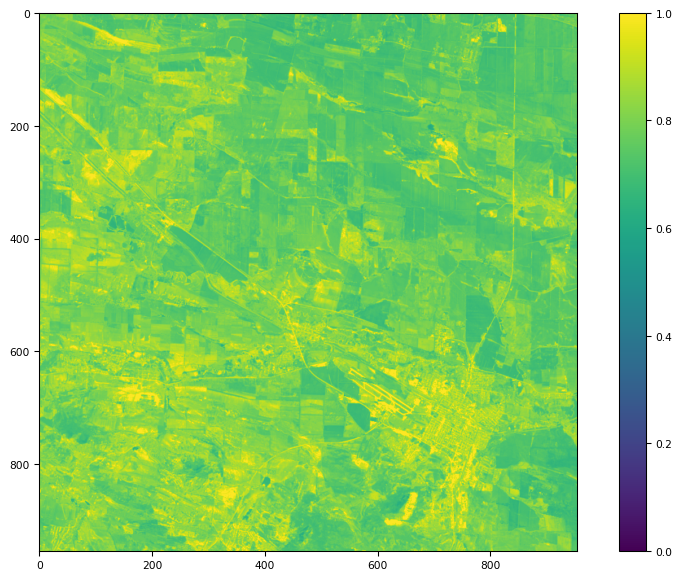

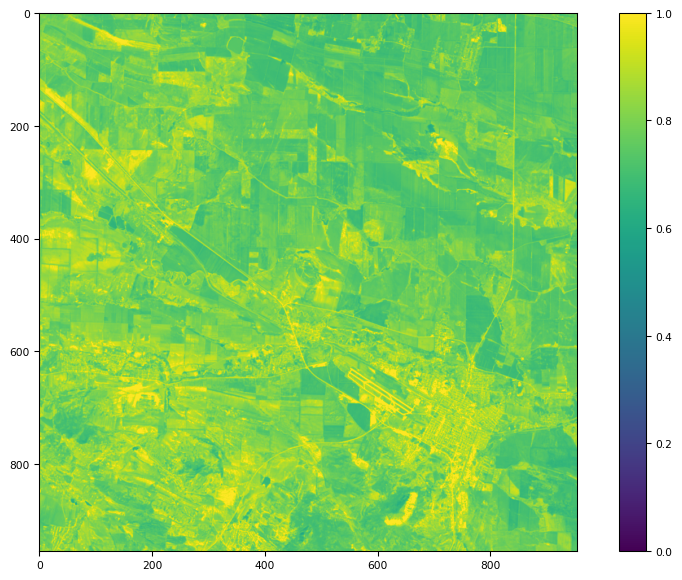

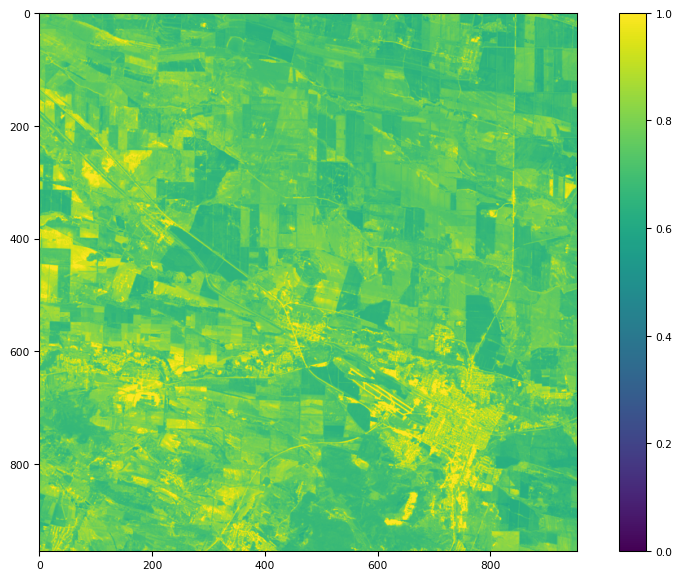

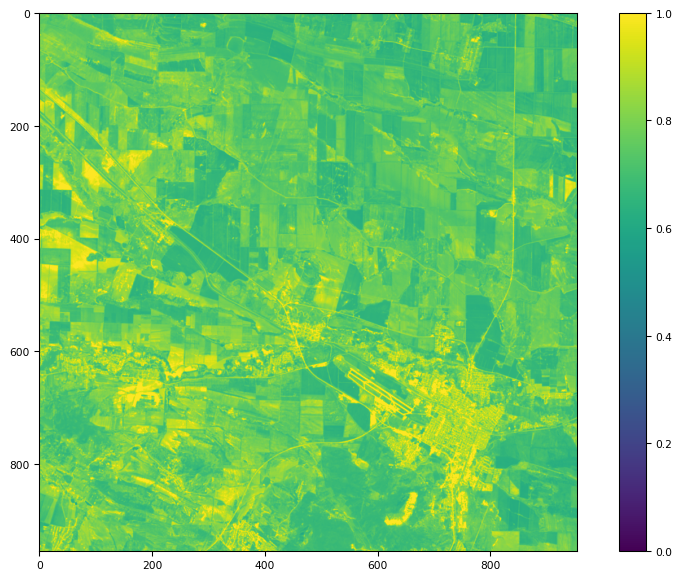

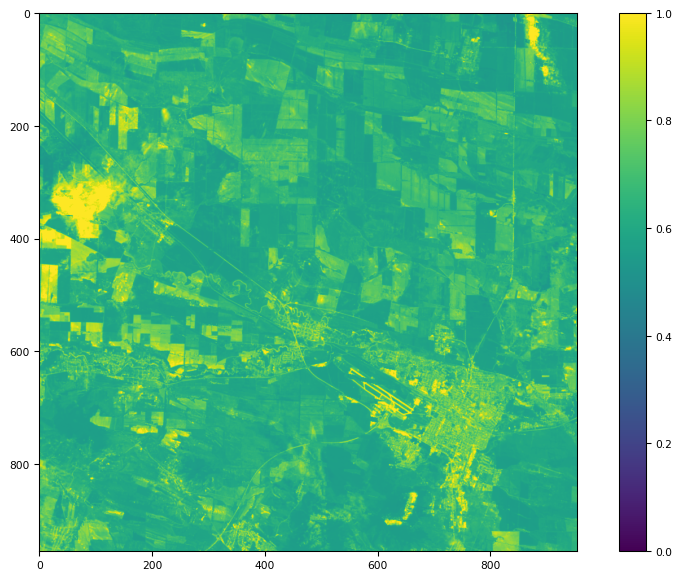

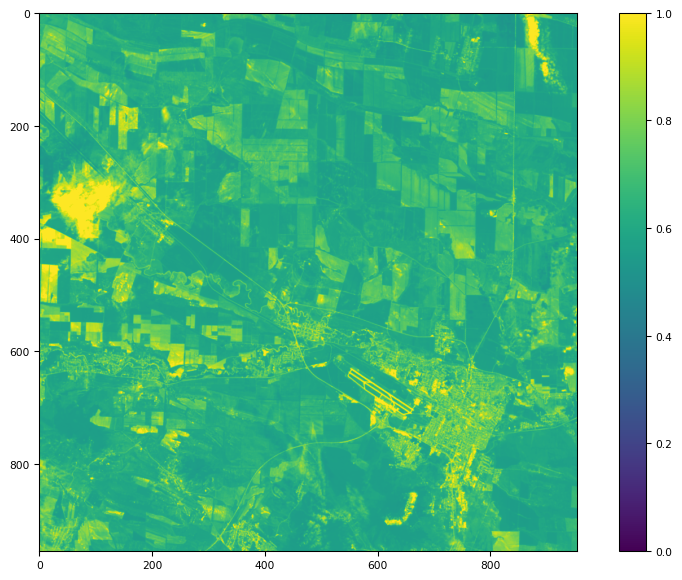

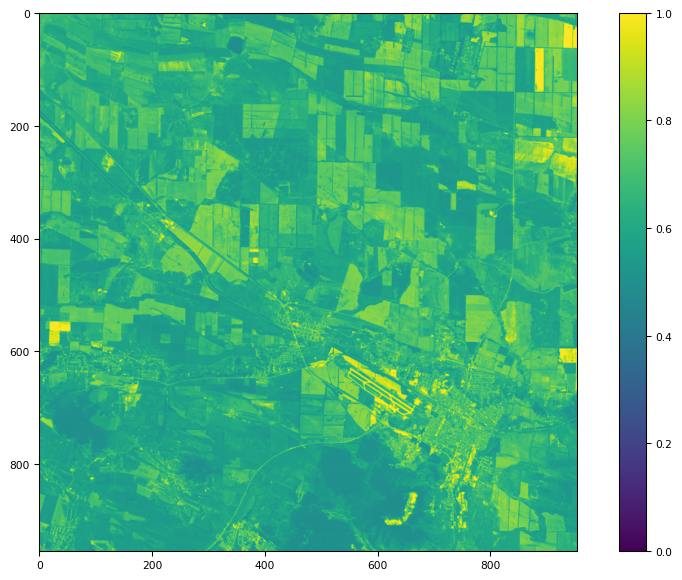

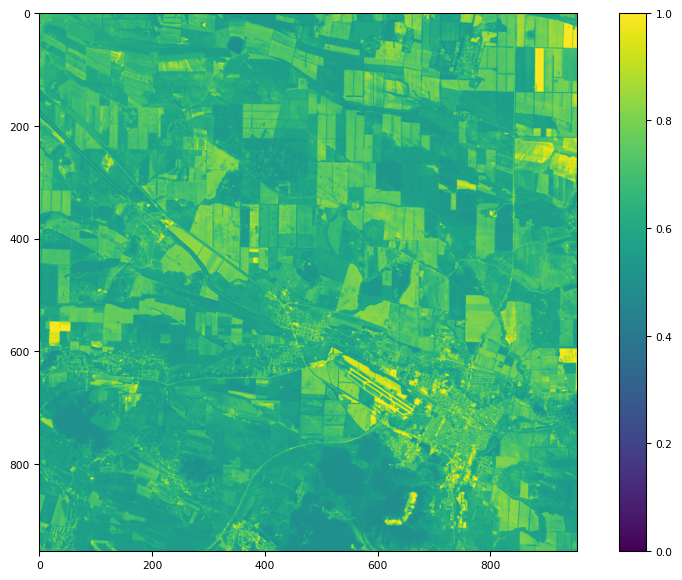

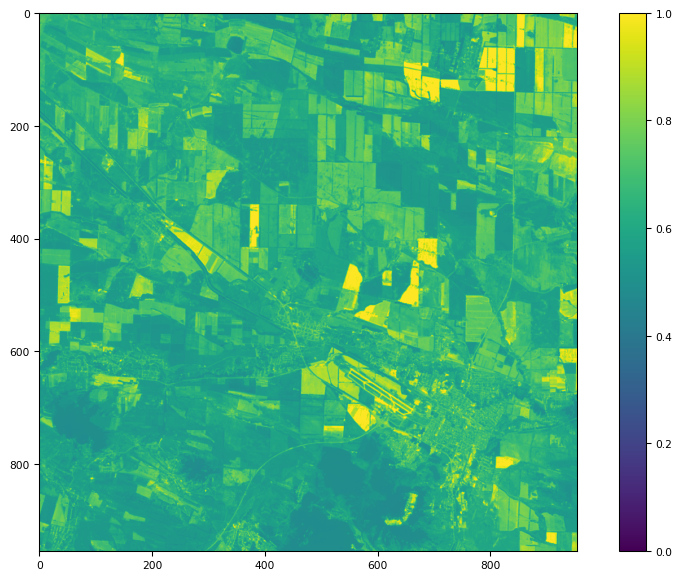

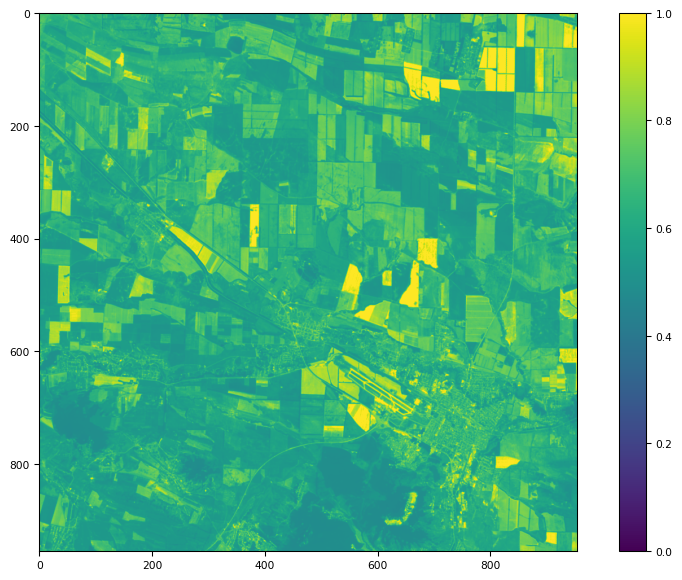

In [11]:
for i in range(len(img)):
    imshow(img[i], vmax=1, vmin=0)
    imshow(img2[i, :, :, 0], vmax=1, vmin=0)

In [12]:
from sklearn.metrics import mean_absolute_error

In [13]:
for target_image_number in range(5):
    print(mean_absolute_error(img2[target_image_number, :, :, 0].reshape(-1), img[target_image_number].reshape(-1)))

0.008931532718793949
0.008677048724429726
0.006626913684620679
0.005036907375402596
0.005762476078663702
